In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('./Data/Currencies/gold.csv', index_col='Date', parse_dates=['Date'], usecols=['Date', 'Close'])
data.head()

,Close
Date,
2016-06-01,1318.400024
2016-07-01,1349.000000
2016-08-01,1306.900024
2016-09-01,1313.300049
2016-10-01,1271.500000


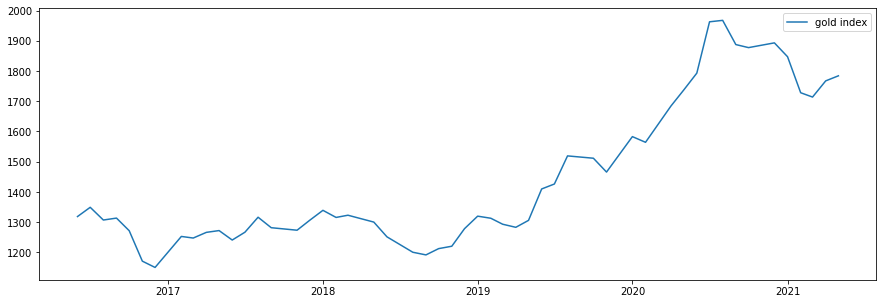

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
ax.plot(data, label='gold index')
plt.legend()
plt.show()

Test stats            -0.252987
p-value                0.931904
lags used              0.000000
n observations        51.000000
1% critical value     -3.565624
5% critical value     -2.920142
10% critical value    -2.598015
dtype: float64


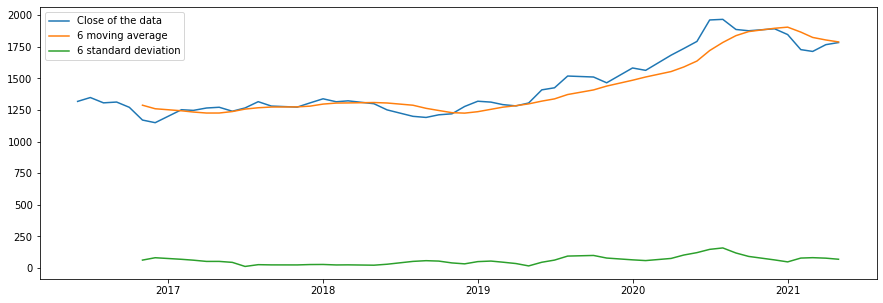

In [4]:
# test for the stationarity of the data
def test_stationarity(data, key='Close', window=6):
    data['ma'] = data[key].rolling(window=window).mean()
    data['mstd'] = data[key].rolling(window=window).std()
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    ax.plot(data[key], label='%s of the data'%key)
    ax.plot(data['ma'], label='%d moving average'%window)
    ax.plot(data['mstd'], label='%d standard deviation'%window)
    plt.legend()
    test = adfuller(data[key].dropna(), autolag='AIC')
    
    out = pd.Series(test[0:4], index=['Test stats', 'p-value', 'lags used', 'n observations'])
    
    for key, value in test[4].items():
        out['%s critical value'%key] = value
    print(out)

test_stationarity(data)

Test stats            -0.263293
p-value                0.930545
lags used              0.000000
n observations        51.000000
1% critical value     -3.565624
5% critical value     -2.920142
10% critical value    -2.598015
dtype: float64


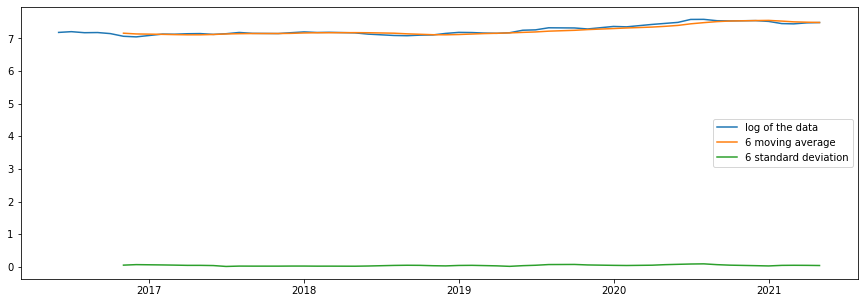

In [5]:
data['log'] = np.log(data['Close'])

test_stationarity(data, key='log')

Test stats            -1.786071
p-value                0.387399
lags used              7.000000
n observations        39.000000
1% critical value     -3.610400
5% critical value     -2.939109
10% critical value    -2.608063
dtype: float64


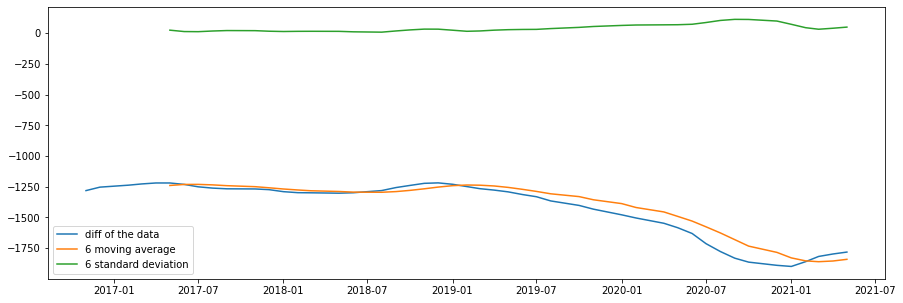

In [6]:
data['logmv'] = data['Close'].rolling(6).mean()
data['logstd'] = data['Close'].rolling(6).std()

data['diff'] = data['log']-data['logmv']
test_stationarity(data, key='diff')

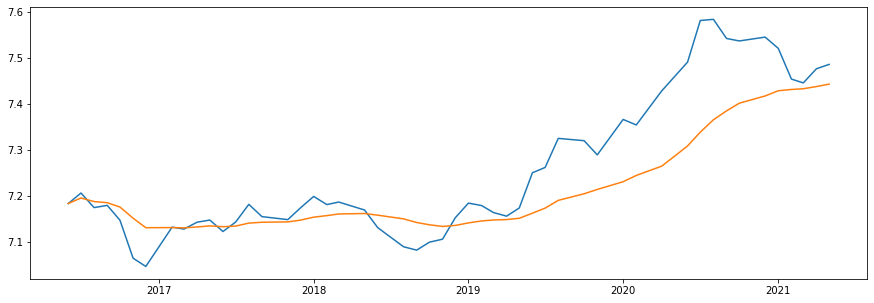

In [7]:
data['exponent'] = data['log'].ewm(halflife=6).mean()
plt.figure(figsize=(15,5))
plt.plot(data['log'])
plt.plot(data['exponent'])
plt.show()

Test stats            -1.611741
p-value                0.477062
lags used              0.000000
n observations        51.000000
1% critical value     -3.565624
5% critical value     -2.920142
10% critical value    -2.598015
dtype: float64


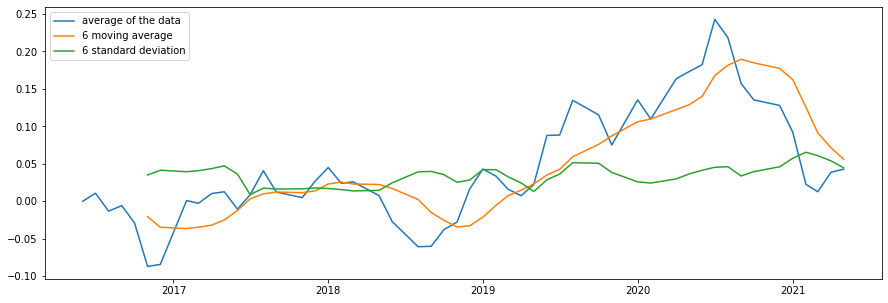

In [8]:
data['average'] = data['log'] - data['exponent']
test_stationarity(data, key='average')

Test stats           -5.992712e+00
p-value               1.730342e-07
lags used             0.000000e+00
n observations        5.000000e+01
1% critical value    -3.568486e+00
5% critical value    -2.921360e+00
10% critical value   -2.598662e+00
dtype: float64


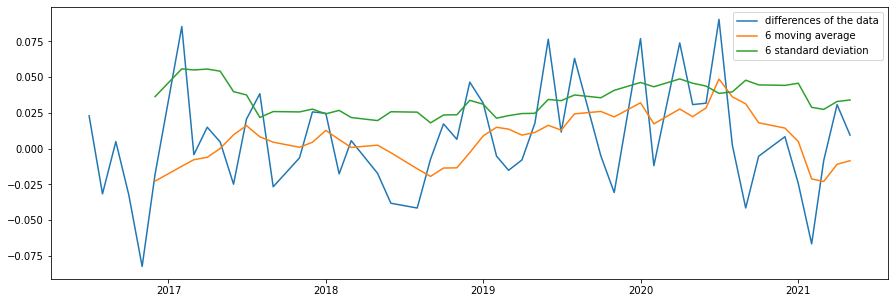

In [9]:
data['differences'] = data['log'] - data['log'].shift(1)
test_stationarity(data, key='differences')

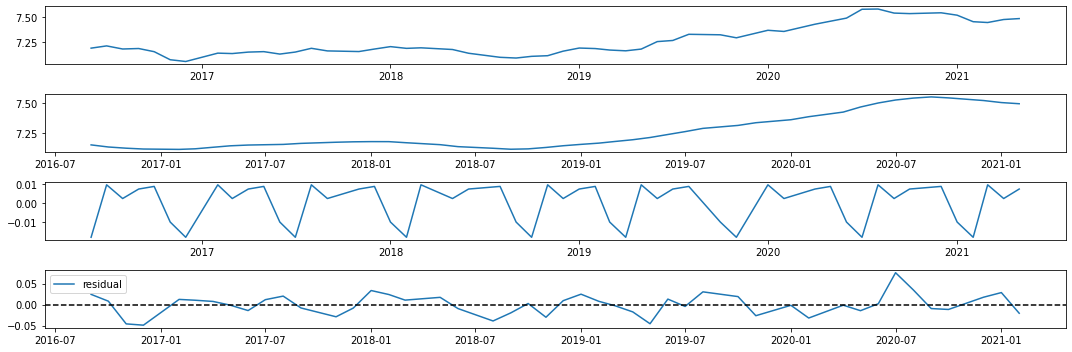

In [10]:
results = seasonal_decompose(data['log'], period=6)

trend = results.trend

seasonality = results.seasonal

residual = results.resid

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(15,5))

ax1.plot(data['log'], label='original data')

ax2.plot(trend, label='trend values')

ax3.plot(seasonality, label='seasonality')

ax4.plot(residual, label='residual')
ax4.axhline(0, ls='--', color='black')

plt.legend()

plt.tight_layout()
plt.show()

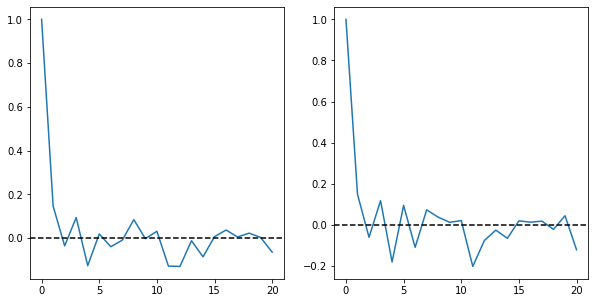

In [11]:
import warnings
warnings.filterwarnings('ignore')

acfd = acf(data['differences'].dropna(), nlags=20, fft=False)
pacfd = pacf(data['differences'].dropna(), nlags=20)

fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(10,5))
ax.plot(acfd)
ax.axhline(0, ls='--', color='black')
ax2.plot(pacfd)
ax2.axhline(0, ls='--', color='black')
plt.show()

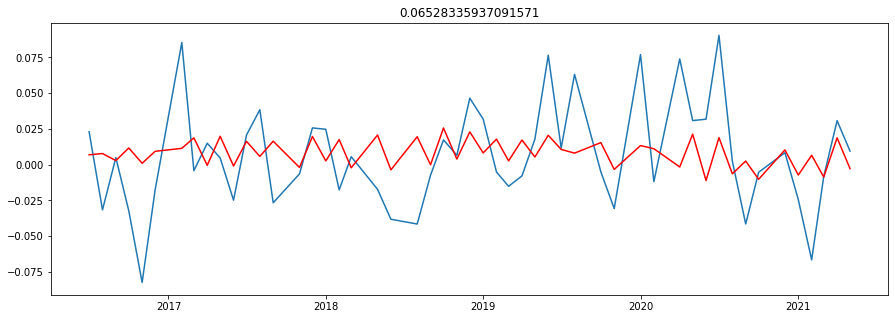

In [14]:
arima = ARIMA(data['log'],order=(2,1,2))
res = arima.fit()

plt.figure(figsize=(15,5))
plt.title(sum((res.fittedvalues - data['differences'].dropna())**2))
plt.plot(data['differences'])
plt.plot(res.fittedvalues, color='red')
plt.show()

data['fitted'] = res.fittedvalues

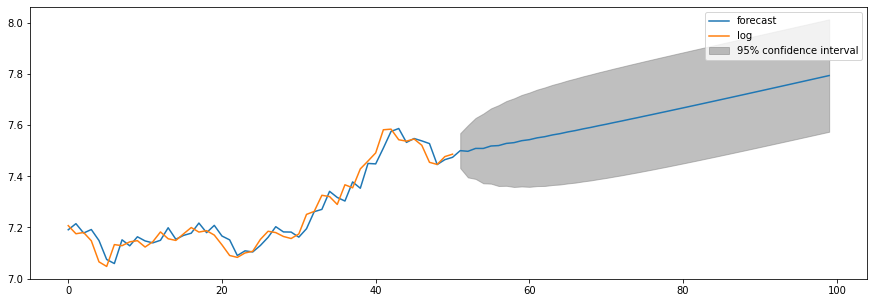

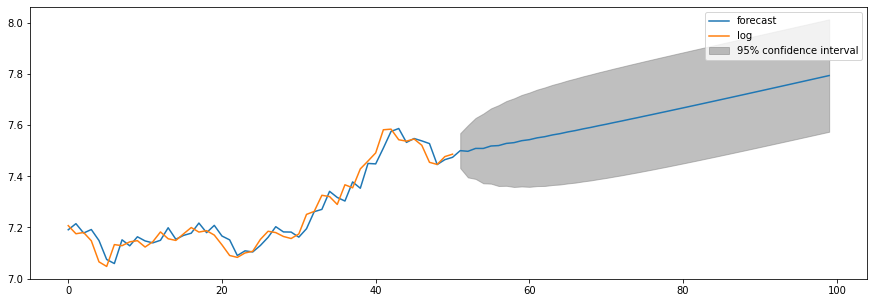

In [15]:
fig, ax =plt.subplots(figsize=(15, 5))
res.plot_predict(1, 100, ax=ax)

In [16]:
data.head()

,Close,ma,mstd,log,logmv,logstd,diff,exponent,average,differences,fitted
Date,,,,,,,,,,,
2016-06-01,1318.400024,NaN,NaN,7.184174,NaN,NaN,NaN,7.184174,0.000000,NaN,NaN
2016-07-01,1349.000000,NaN,NaN,7.207119,NaN,NaN,NaN,7.196308,0.010810,0.022945,0.006860
2016-08-01,1306.900024,NaN,NaN,7.175413,NaN,NaN,NaN,7.188525,-0.013112,-0.031706,0.007742
2016-09-01,1313.300049,NaN,NaN,7.180298,NaN,NaN,NaN,7.186100,-0.005801,0.004885,0.002811
2016-10-01,1271.500000,NaN,NaN,7.147953,NaN,NaN,NaN,7.176614,-0.028662,-0.032346,0.011642


In [17]:
data['sum'] = data['fitted'].cumsum()

In [18]:
data.head(5)

,Close,ma,mstd,log,logmv,logstd,diff,exponent,average,differences,fitted,sum
Date,,,,,,,,,,,,
2016-06-01,1318.400024,NaN,NaN,7.184174,NaN,NaN,NaN,7.184174,0.000000,NaN,NaN,NaN
2016-07-01,1349.000000,NaN,NaN,7.207119,NaN,NaN,NaN,7.196308,0.010810,0.022945,0.006860,0.006860
2016-08-01,1306.900024,NaN,NaN,7.175413,NaN,NaN,NaN,7.188525,-0.013112,-0.031706,0.007742,0.014602
2016-09-01,1313.300049,NaN,NaN,7.180298,NaN,NaN,NaN,7.186100,-0.005801,0.004885,0.002811,0.017414
2016-10-01,1271.500000,NaN,NaN,7.147953,NaN,NaN,NaN,7.176614,-0.028662,-0.032346,0.011642,0.029056


In [19]:
data['predictionslogscale'] = data['sum'] + data['log']

In [20]:
data.head()

,Close,ma,mstd,log,logmv,logstd,diff,exponent,average,differences,fitted,sum,predictionslogscale
Date,,,,,,,,,,,,,
2016-06-01,1318.400024,NaN,NaN,7.184174,NaN,NaN,NaN,7.184174,0.000000,NaN,NaN,NaN,NaN
2016-07-01,1349.000000,NaN,NaN,7.207119,NaN,NaN,NaN,7.196308,0.010810,0.022945,0.006860,0.006860,7.213979
2016-08-01,1306.900024,NaN,NaN,7.175413,NaN,NaN,NaN,7.188525,-0.013112,-0.031706,0.007742,0.014602,7.190015
2016-09-01,1313.300049,NaN,NaN,7.180298,NaN,NaN,NaN,7.186100,-0.005801,0.004885,0.002811,0.017414,7.197712
2016-10-01,1271.500000,NaN,NaN,7.147953,NaN,NaN,NaN,7.176614,-0.028662,-0.032346,0.011642,0.029056,7.177008


In [21]:
data['predictedactual'] = np.exp(data['predictionslogscale'])
data.head()

,Close,ma,mstd,log,logmv,logstd,diff,exponent,average,differences,fitted,sum,predictionslogscale,predictedactual
Date,,,,,,,,,,,,,,
2016-06-01,1318.400024,NaN,NaN,7.184174,NaN,NaN,NaN,7.184174,0.000000,NaN,NaN,NaN,NaN,NaN
2016-07-01,1349.000000,NaN,NaN,7.207119,NaN,NaN,NaN,7.196308,0.010810,0.022945,0.006860,0.006860,7.213979,1358.285721
2016-08-01,1306.900024,NaN,NaN,7.175413,NaN,NaN,NaN,7.188525,-0.013112,-0.031706,0.007742,0.014602,7.190015,1326.123637
2016-09-01,1313.300049,NaN,NaN,7.180298,NaN,NaN,NaN,7.186100,-0.005801,0.004885,0.002811,0.017414,7.197712,1336.369505
2016-10-01,1271.500000,NaN,NaN,7.147953,NaN,NaN,NaN,7.176614,-0.028662,-0.032346,0.011642,0.029056,7.177008,1308.986489


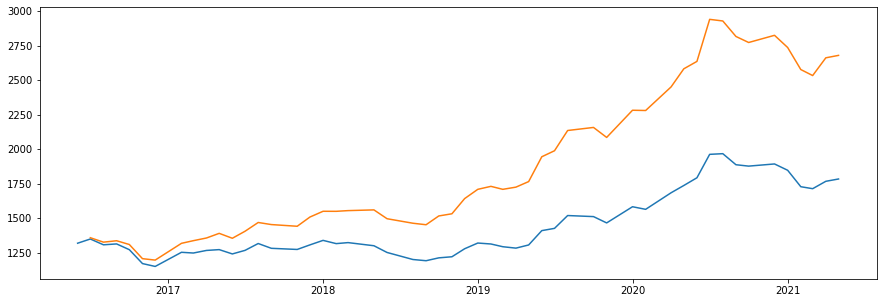

In [22]:
plt.figure(figsize=(15,5))
plt.plot(data['Close'])
plt.plot(data['predictedactual'])
plt.show()

In [23]:
# freeze the output to another csv file

import seaborn as sns

<AxesSubplot:ylabel='Date'>

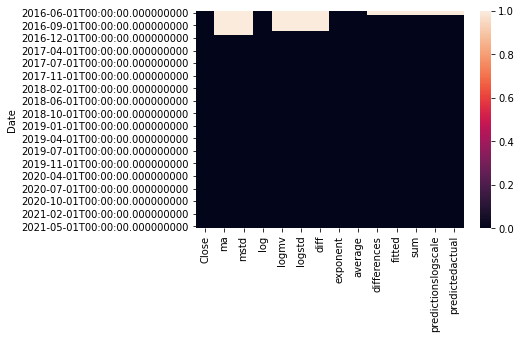

In [24]:
sns.heatmap(data.isnull())

In [25]:
data.to_csv('./Data/Currencies/goldpred.csv')